In [1]:
import seaborn as sns
import pandas as pd
import numpy as np 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

DATA_PATH = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/meetings/"

# Google Slides [Summary] of Results 


# Read in

In [34]:
df = pd.read_csv(DATA_PATH + "2024_04_29_JC_meeting.csv")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_15269/1345217217.py:1: DtypeWarning: Columns (54,69,70,71,74,82,87,89,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH + "2024_04_29_JC_meeting.csv")


### Assess Features

Below, we can see that the delay dur is a bit complicated in this scenario. When in stages 5-7 (fixation growing, no violation penalty), the delay dur is parameterized by the settling_in_dur. This allows the animal to rapidly retry without penalty.

In stages 8 and above, the delay dur is parameterized by the pre_go_dur. This does not take into account the settling_in_dur explicitly when the stimuli are off (stage 8 only).

In stage 8, then, the required fixation time is the pre_go_dur + the settling_in_dur. In stage 9 onward (when stimuli are on), pre_go_dur takes into account settling_in_dur. Training section [here](https://github.com/Brody-Lab/Protocols/blob/master/%40DMS2/TS_JB_r_classic.m#L598) and Shaping Section [here](https://github.com/Brody-Lab/Protocols/blob/master/%40DMS2/ShapingSection.m#L1585)

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Settling in Dur Stage 5-8 for R020')]

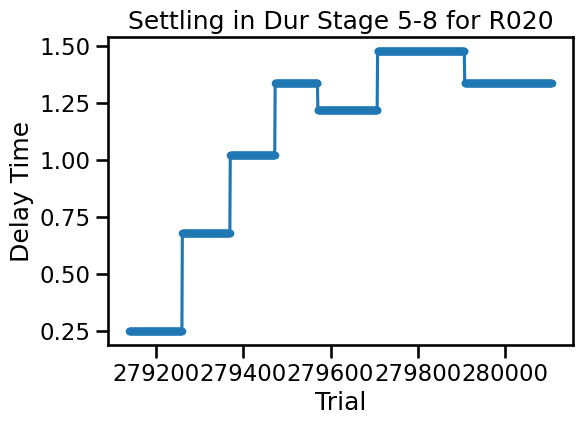

In [36]:
single_animal = "R020"
subdf = df.query("animal_id == @single_animal and stage >=5 and stage<8")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(subdf.settling_in_dur, marker=".")

    ylabel="Delay Time",
    xlabel="Trial",
    title=f"Settling in Dur Stage 5-8 for {single_animal}",
)

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Pre Go Dur Stage 5-9 for R020')]

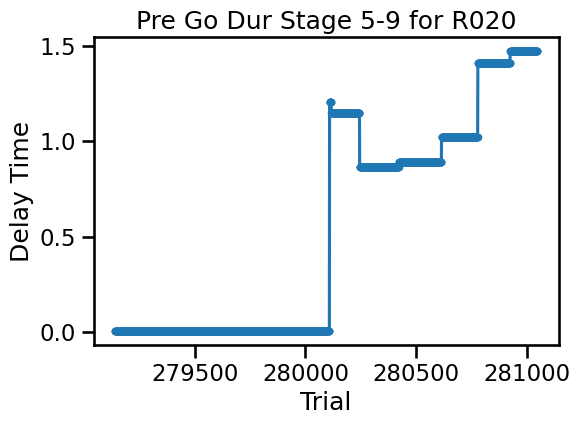

In [33]:
single_animal = "R020"
subdf = df.query("animal_id == @single_animal and stage >=5 and stage<9")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(subdf.pre_go_dur, marker=".")

ax.set(
    ylabel="Delay Time",
    xlabel="Trial",
    title=f"Pre Go Dur Stage 5-9 for {single_animal}",
)

## Data Wrangling to do

List of things needed:
1. Truncate at stage 11
2. Subset columns- 
    > ['trial', 'animal_id', 'date', 'sess_id', 'hits', 'stage', 'sa', 'sb',
       'stimuli_on', 'settling_in_dur', 'legal_cbreak_dur', 'pre_dur',
       'adj_pre_dur', 'stimulus_dur', 'delay_dur', 'post_dur', 'sb_extra_dur'
       'viol_off_dur', 'pre_go_dur', 'sound_pair', 'give_type_imp', 'give_frac', 'n_settling_ins', 'avg_settling_in', 'cpoke_dur']
3. Session number relative to the start of stage 5 for each animal
4. "fixation_dur" column that has stage specific logic 
   
    5. Stage 5-7, `fixation_dur = settling_in_dur`

    6. Stage 8, `fixation_dur = settling_in_dur + pre_go_dur`
    
    7. Stage 9-onwards `fixation_dur = pre_go_dur`


This will allow for making plots for each animal
* raw fixation dur over trials (focusing on stages 5-8)

* raw required vs actual dur over trials 

* fixation time max by session 

* number of sessions to 1.4s fixation

* violation rate by session to 1.5s fixation

    * pre stage 8 will be "retry_rate"

    * stage 8 onward will be "violation_rate"

* average violation rate early (stage 8)

* average violation rate late (stage 11 when there is no LG)

    * need to get count of trials for each animal here- might be a little messy


## Raw Data of delay over trials for each animal

In [6]:
df.columns

Index(['trial', 'animal_id', 'date', 'sess_id', 'result', 'hits', 'violations',
       'temperror', 'hit_rate', 'error_rate', 'violation_rate',
       'temp_error_rate', 'n_lpokes', 'n_cpokes', 'n_rpokes', 'trial_dur',
       'trial_start', 'valid_early_spoke', 'first_spoke', 'first_lpoke',
       'first_rpoke', 'n_settling_ins', 'avg_settling_in', 'cpoke_dur',
       'stage', 'curriculum', 'sides', 'SMA_set', 'is_match', 'sa', 'sb',
       'stimuli_on', 'settling_in_dur', 'legal_cbreak_dur', 'pre_dur',
       'adj_pre_dur', 'stimulus_dur', 'delay_dur', 'post_dur', 'sb_extra_dur',
       'viol_off_dur', 'pre_go_dur', 'inter_trial_dur', 'go_type', 'go_dur',
       'give_type_set', 'give_type_imp', 'give_frac', 'give_delay_dur',
       'give_xtra_light_delay_dur', 'give_use', 'replay_on', 'timeouts',
       'water_delivered', 'give_water_not_drunk', 'crash_hist',
       'was_block_swtich', 'volume_multiplier', 'l_water_vol', 'r_water_vol',
       'ab_l_prob', 'ab_r_prob', 'ab_beta', 'ab_

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'First 10 sessions for W078')]

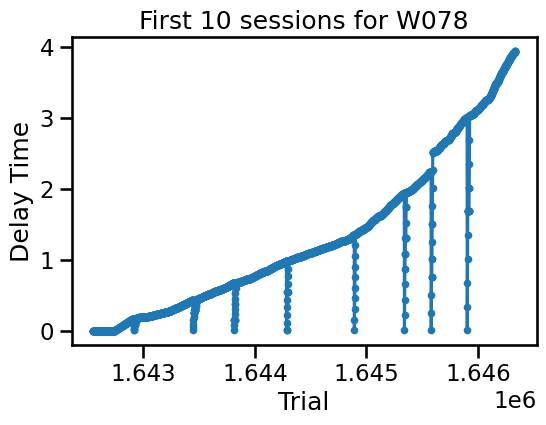

In [138]:
single_animal = "W078"
subdf = df.query("animal_id == @single_animal and session < 10")
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(subdf.delay_time, marker=".")

ax.set(
    ylabel="Delay Time", xlabel="Trial", title=f"First 10 sessions for {single_animal}"
)

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Sesion 10 for W078')]

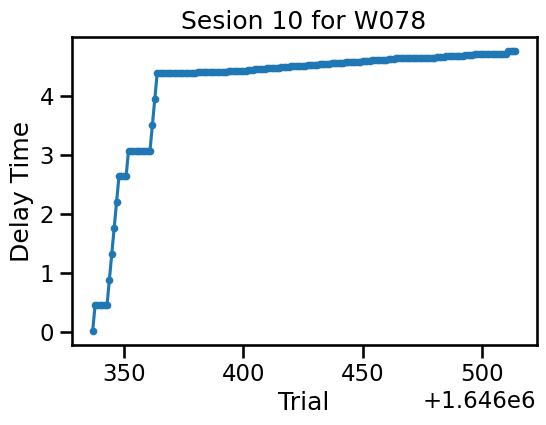

In [139]:
single_animal = "W078"
subdf = df.query("animal_id == @single_animal and session == 10")
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(subdf.delay_time, marker=".")

ax.set(ylabel="Delay Time", xlabel="Trial", title=f"Sesion 10 for {single_animal}")

## All delay times over trials in stage 1

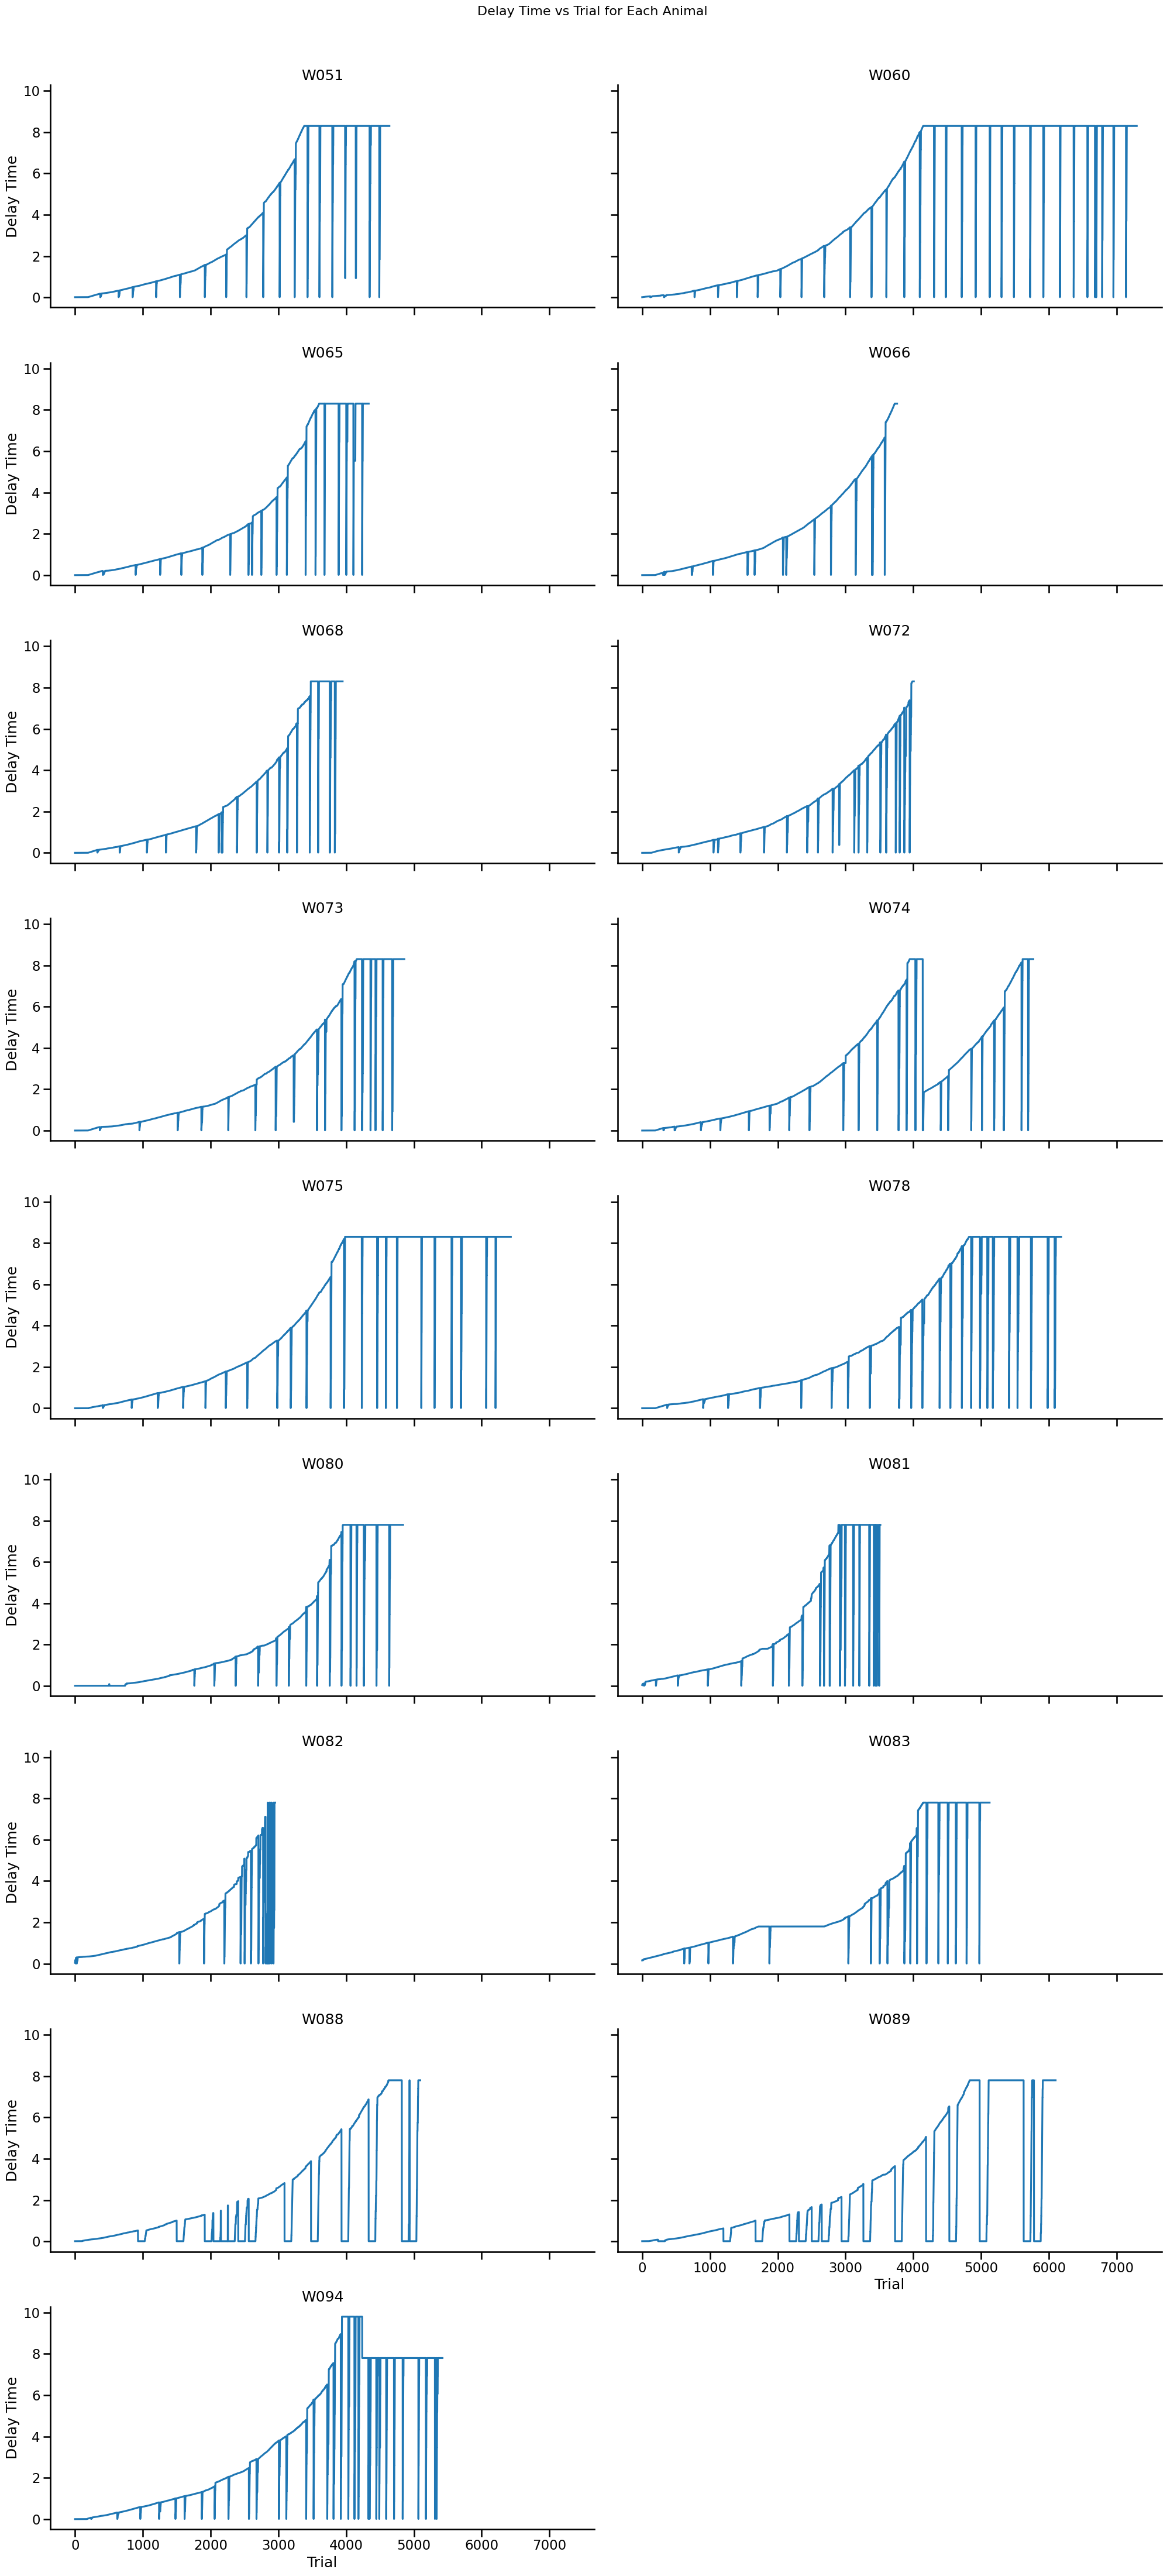

In [22]:
def matplolib_plot(y, **kwargs):
    x = np.arange(len(y))
    plt.plot(x, y, **kwargs)


# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    df.query("training_stage == 1"), col="animal_id", col_wrap=2, height=5, aspect=2
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "delay_time")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Delay Time vs Trial for Each Animal", fontsize=16)
g.set_axis_labels("Trial", "Delay Time")

## Repeat but for sessions with delay times less than 1.5 seconds

In [36]:
def filter_sessions_by_delay_time(df, threshold):
    """
    Filters the DataFrame to only include sessions where the maximum delay_time is below the given threshold for each animal.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'animal_id', 'session_id', 'trial', and 'delay_time'.
    threshold (float): The maximum allowed delay_time for a session to be included.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only the rows where the maximum delay_time for the session is below the threshold.
    """
    # Step 1: Group by animal_id and session_id, and calculate the maximum delay_time for each session
    max_delay_time_per_session = (
        df.groupby(["animal_id", "session"])["delay_time"].max().reset_index()
    )

    # Step 2: Filter sessions where the maximum delay_time is below the threshold for each animal
    filtered_sessions = max_delay_time_per_session[
        max_delay_time_per_session["delay_time"] < threshold
    ]

    # Step 3: Filter the original DataFrame to only include rows from the filtered sessions for each animal
    filtered_df = df[
        df.set_index(["animal_id", "session"]).index.isin(
            filtered_sessions.set_index(["animal_id", "session"]).index
        )
    ]

    return filtered_df

In [76]:
def filter_sessions_up_to_threshold(df, threshold):
    """
    Filters the DataFrame to include all sessions for each animal leading up to (and including) the first session
    where the maximum delay_time is above the given threshold.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'animal_id', 'session_id', 'trial', and 'delay_time'.
    threshold (float): The threshold above which we stop including sessions.

    Returns:
    pd.DataFrame: A filtered DataFrame containing sessions leading up to (and including) the first session
                  where the maximum delay_time is above the threshold for each animal.
    """
    # Step 1: Group by animal_id and session_id, and calculate the maximum delay_time for each session
    max_delay_time_per_session = (
        df.groupby(["animal_id", "session"])["delay_time"].max().reset_index()
    )

    dfs = []

    # Step 2: Iterate over each animal_id
    for animal_id, group in max_delay_time_per_session.groupby("animal_id"):
        # Step 3: Find the first session where the maximum delay_time is above the threshold
        above_threshold_session = group[group["delay_time"] > threshold]
        if not above_threshold_session.empty:
            first_above_threshold_session = above_threshold_session.iloc[0]["session"]

            print(
                f"animal_id = {animal_id}, above threshold session = {first_above_threshold_session}"
            )

            # Step 4: Grab all sessions to threshold and append
            dfs.append(
                df.query(
                    "animal_id == @animal_id and session <= @first_above_threshold_session"
                )
            )

    # Step 5: Filter the original DataFrame to include only the rows from the sessions to keep
    filtered_df = pd.concat(dfs, ignore_index=True)

    return filtered_df

In [80]:
threshold = 1.5
short_del_df = filter_sessions_up_to_threshold(df, threshold=threshold)

animal_id = W051, above threshold session = 6
animal_id = W060, above threshold session = 8
animal_id = W065, above threshold session = 6
animal_id = W066, above threshold session = 9
animal_id = W068, above threshold session = 6
animal_id = W072, above threshold session = 9
animal_id = W073, above threshold session = 6
animal_id = W074, above threshold session = 7
animal_id = W075, above threshold session = 7
animal_id = W078, above threshold session = 6
animal_id = W080, above threshold session = 7
animal_id = W081, above threshold session = 6
animal_id = W082, above threshold session = 7
animal_id = W083, above threshold session = 5
animal_id = W088, above threshold session = 6
animal_id = W089, above threshold session = 5
animal_id = W094, above threshold session = 9


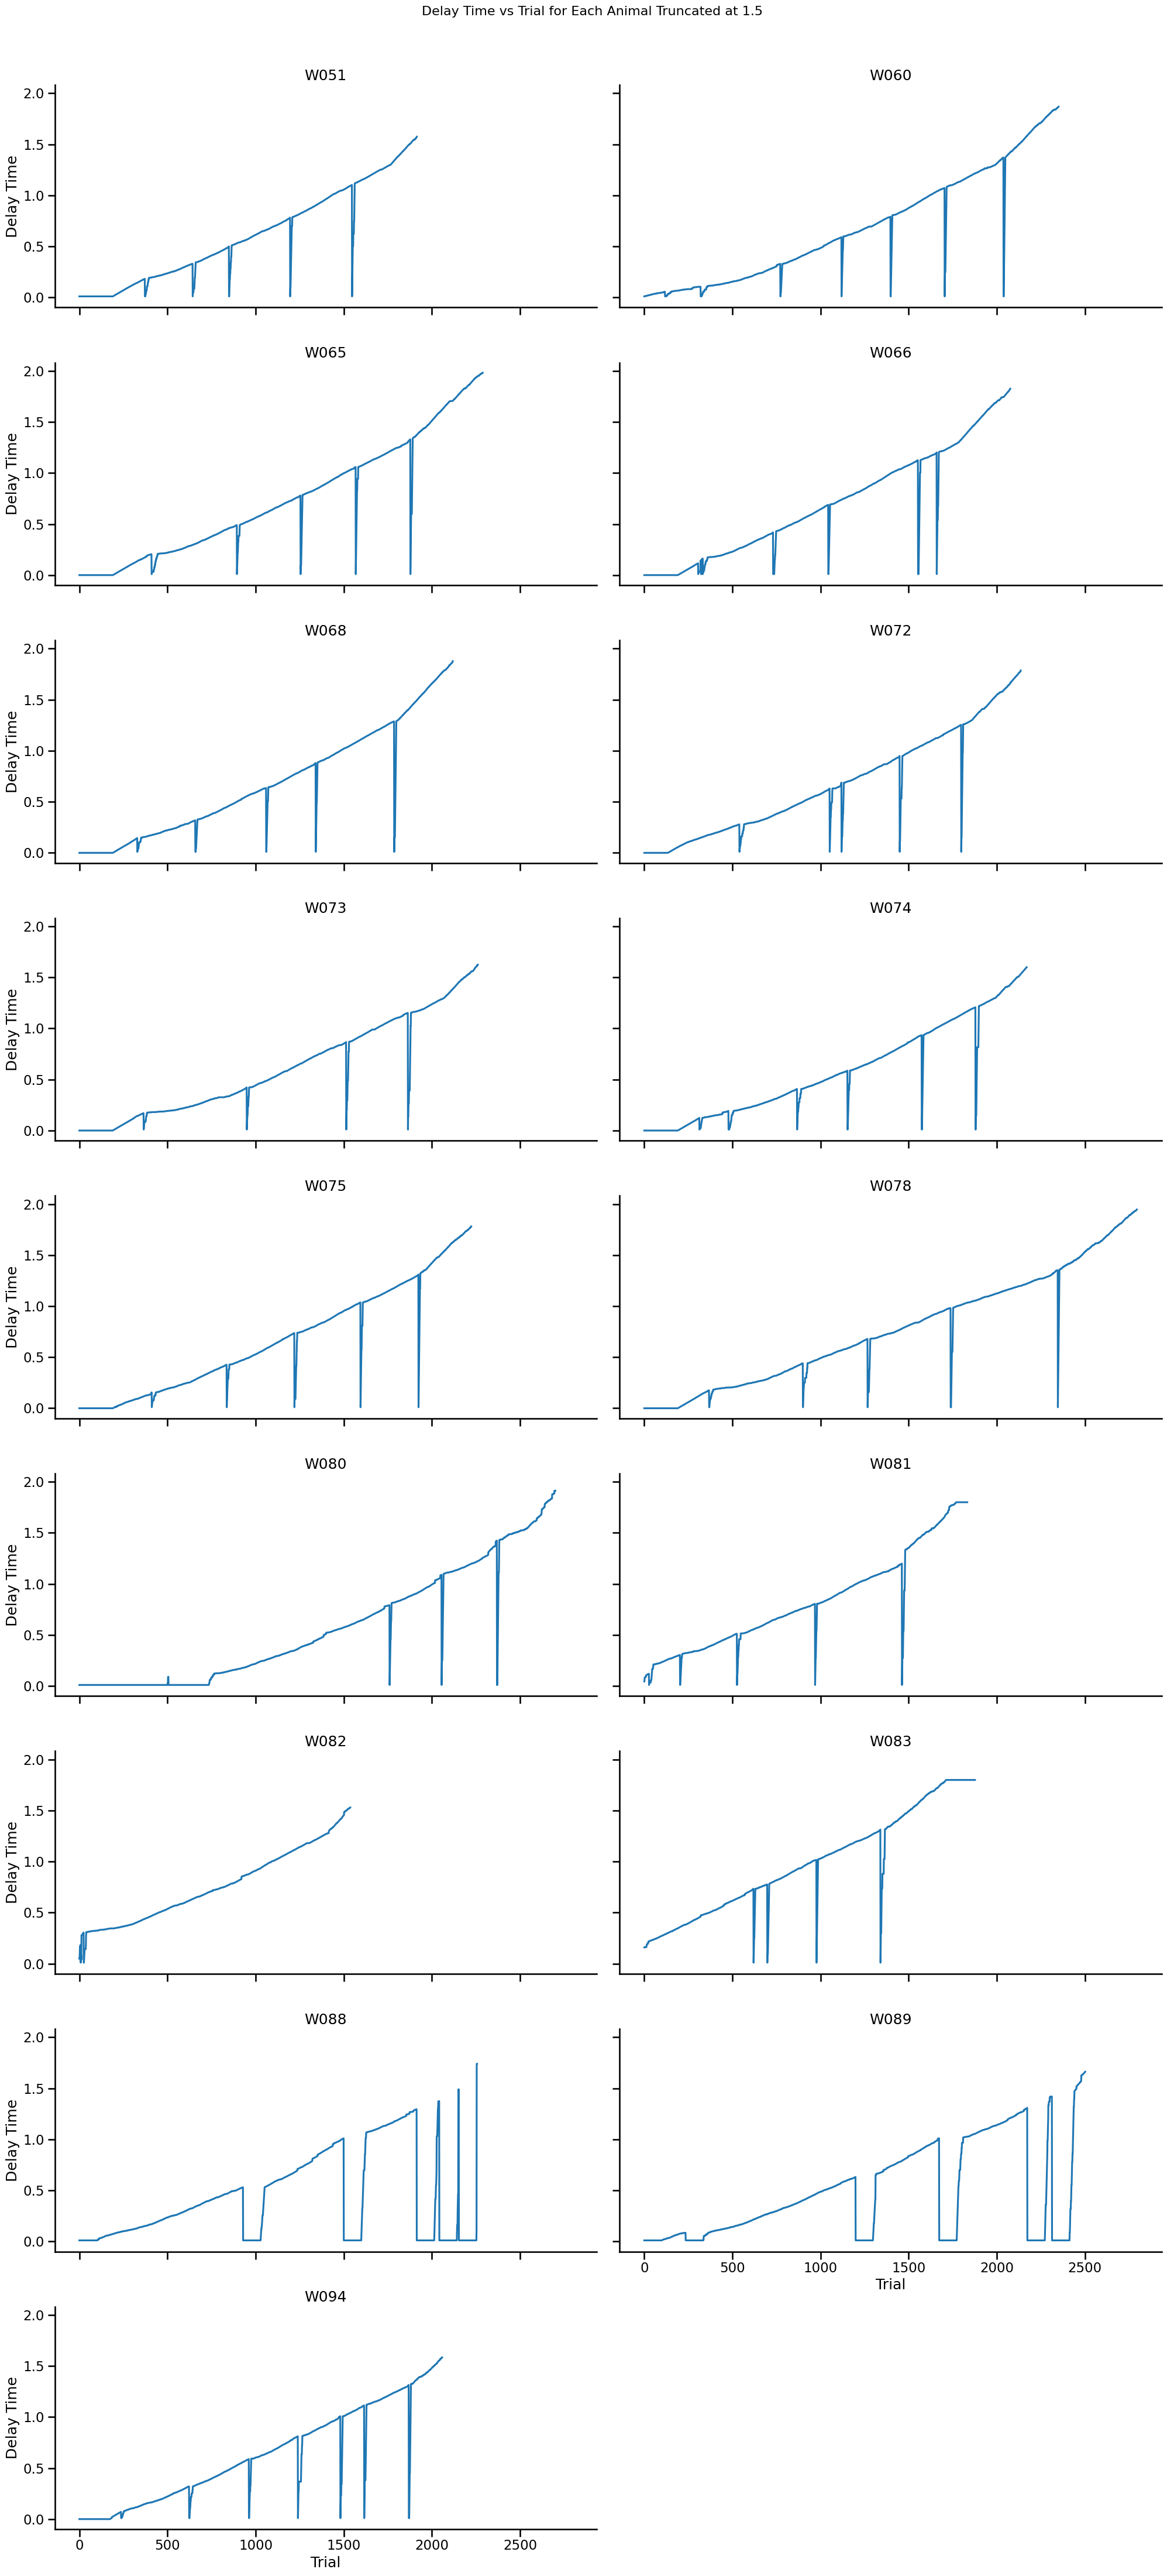

In [81]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df.query("training_stage == 1"),
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "delay_time")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Delay Time vs Trial for Each Animal Truncated at {threshold}", fontsize=16
)
g.set_axis_labels("Trial", "Delay Time")

## Session by Delay Time (threshold at 1.5)



/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_50159/1913002043.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())


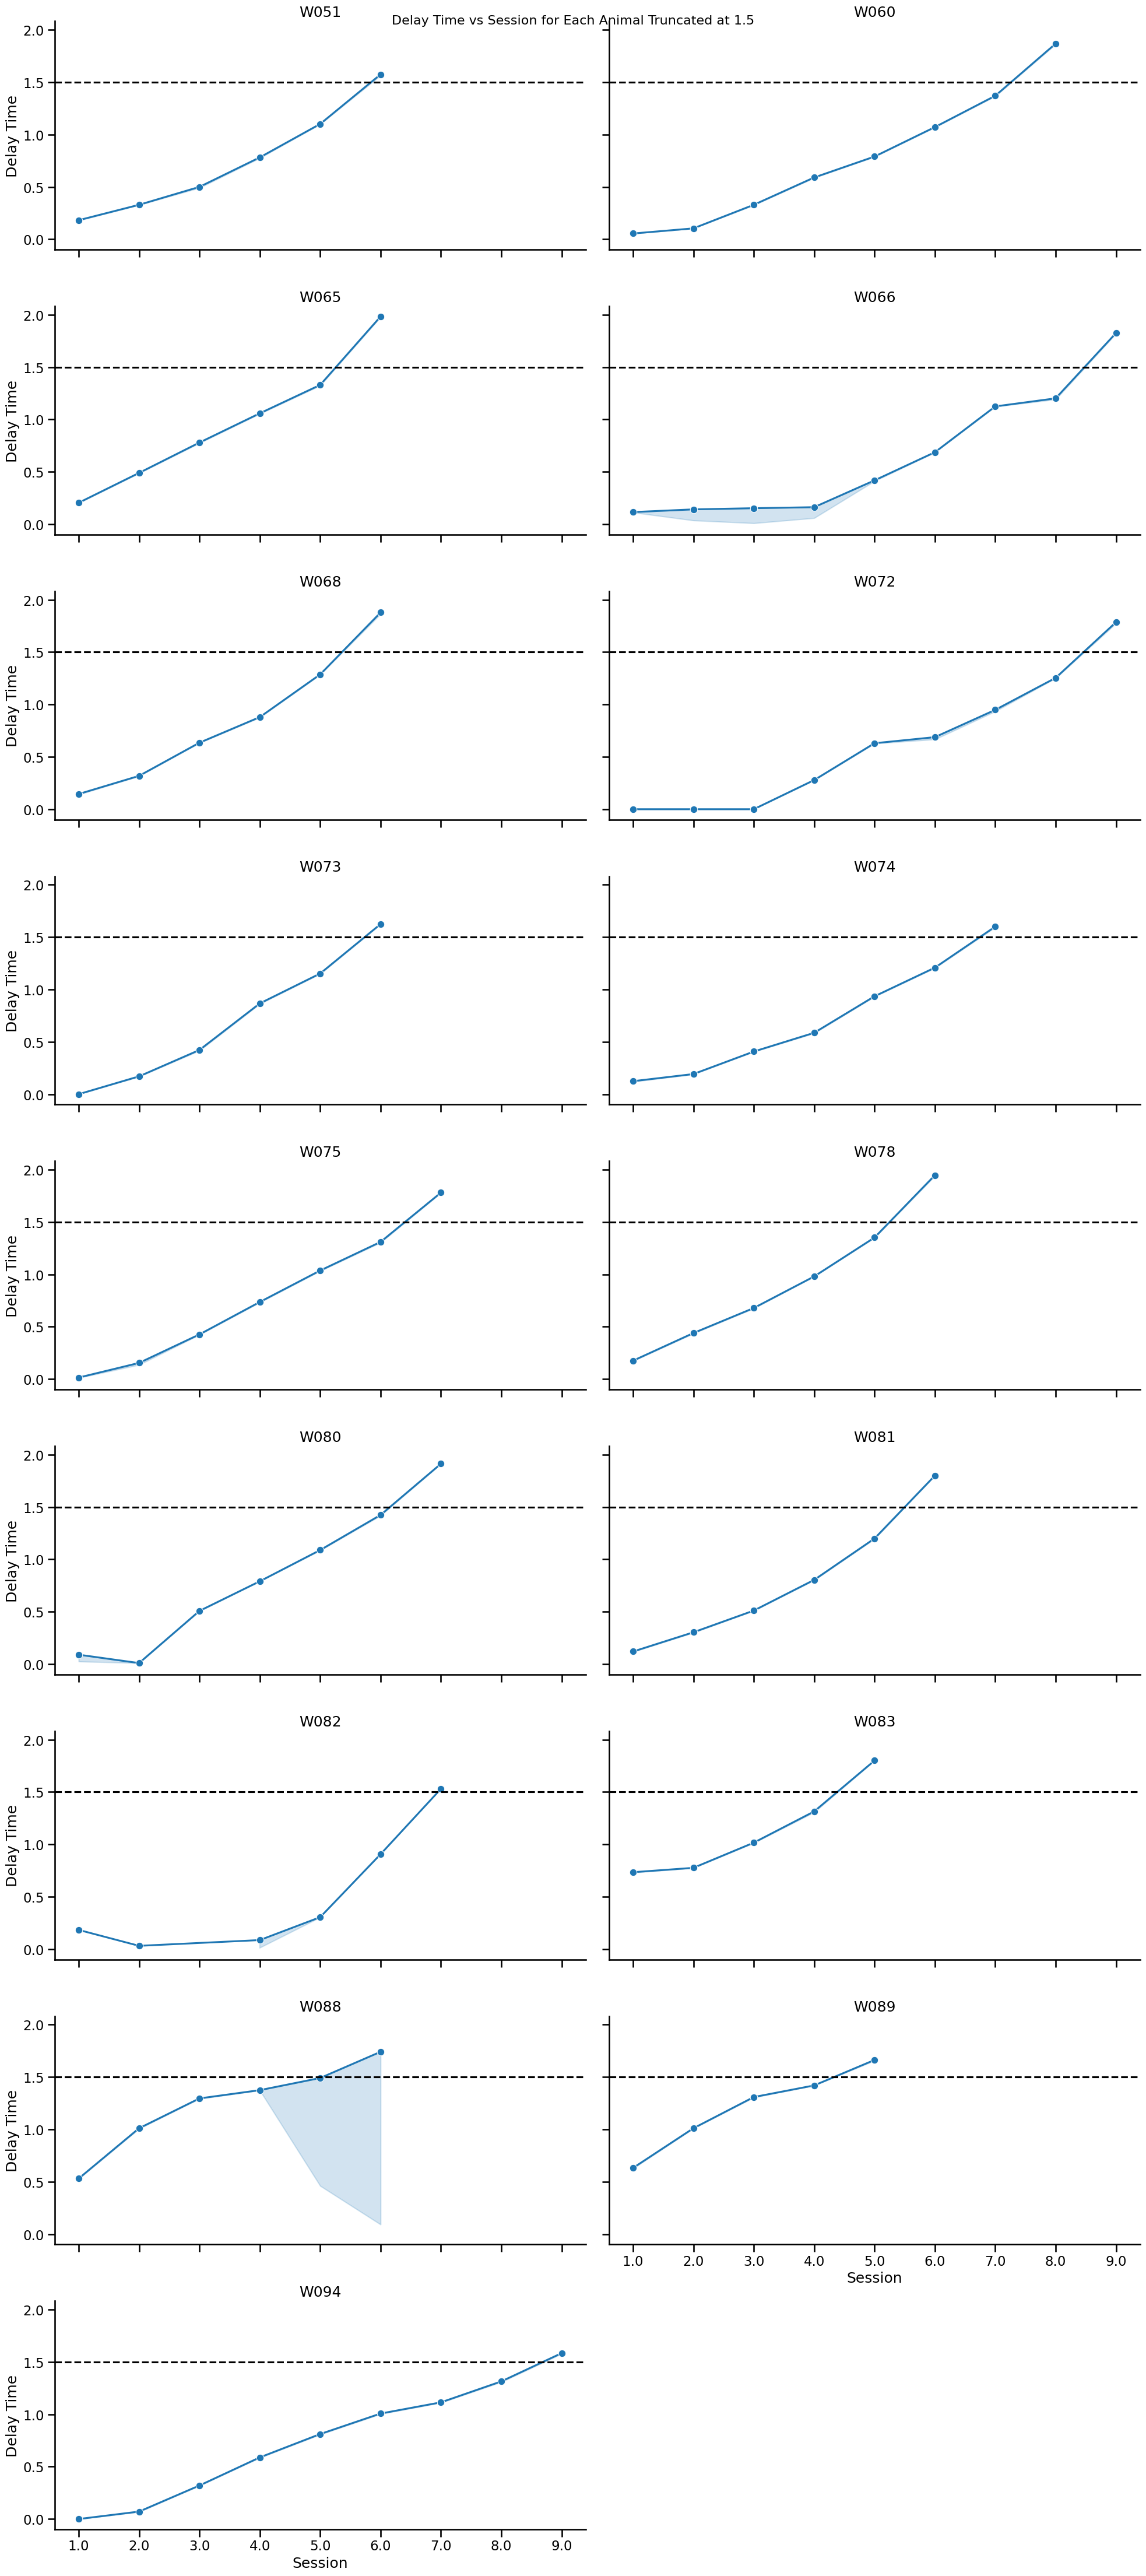

In [140]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df.query("training_stage == 1"),
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(sns.lineplot, "session", "delay_time", marker="o", estimator="max")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Delay Time vs Session for Each Animal Truncated at {threshold}", fontsize=16
)
g.set_axis_labels("Session", "Delay Time")

g.map(plt.axhline, y=1.5, color="k", linestyle="--")
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticks())

## Number of sessions to reach 1.5s

In [159]:
sess_to_gnp_thresh.session.mean()

6.764705882352941

Text(0.5, 1.0, 'Number of Sessions to 1.5s Fixation')

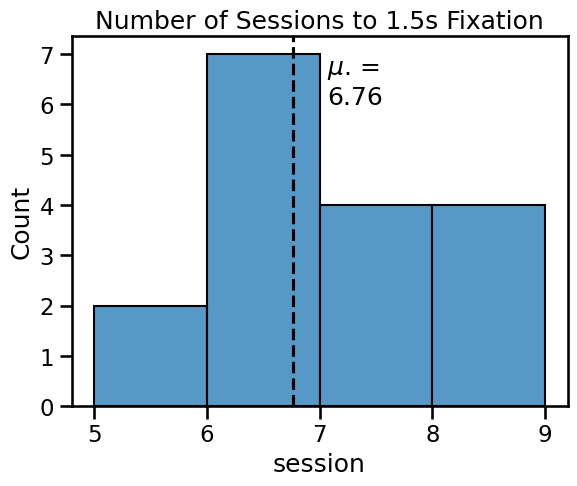

In [165]:
sess_to_gnp_thresh = short_del_df.groupby("animal_id").session.max().reset_index()
sns.histplot(data=sess_to_gnp_thresh, x="session", binwidth=1)

mean = sess_to_gnp_thresh.session.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.3, y=6, s=f"$\mu$. = \n{mean:.2f}")
plt.title("Number of Sessions to 1.5s Fixation")

In [148]:
animals = sess_to_gnp_thresh.animal_id.nunique()
mean = sess_to_gnp_thresh.session.mean().round(2)
std = sess_to_gnp_thresh.session.std().round(2)
median = sess_to_gnp_thresh.session.median()

print(
    f"**Results** \nN animals = {animals}\n"
    f"Mean = {mean} +/- {std} std\n"
    f"Median = {median}"
)

**Results** 
N animals = 17
Mean = 6.76 +/- 1.3 std
Median = 6.0


## Violation Rates

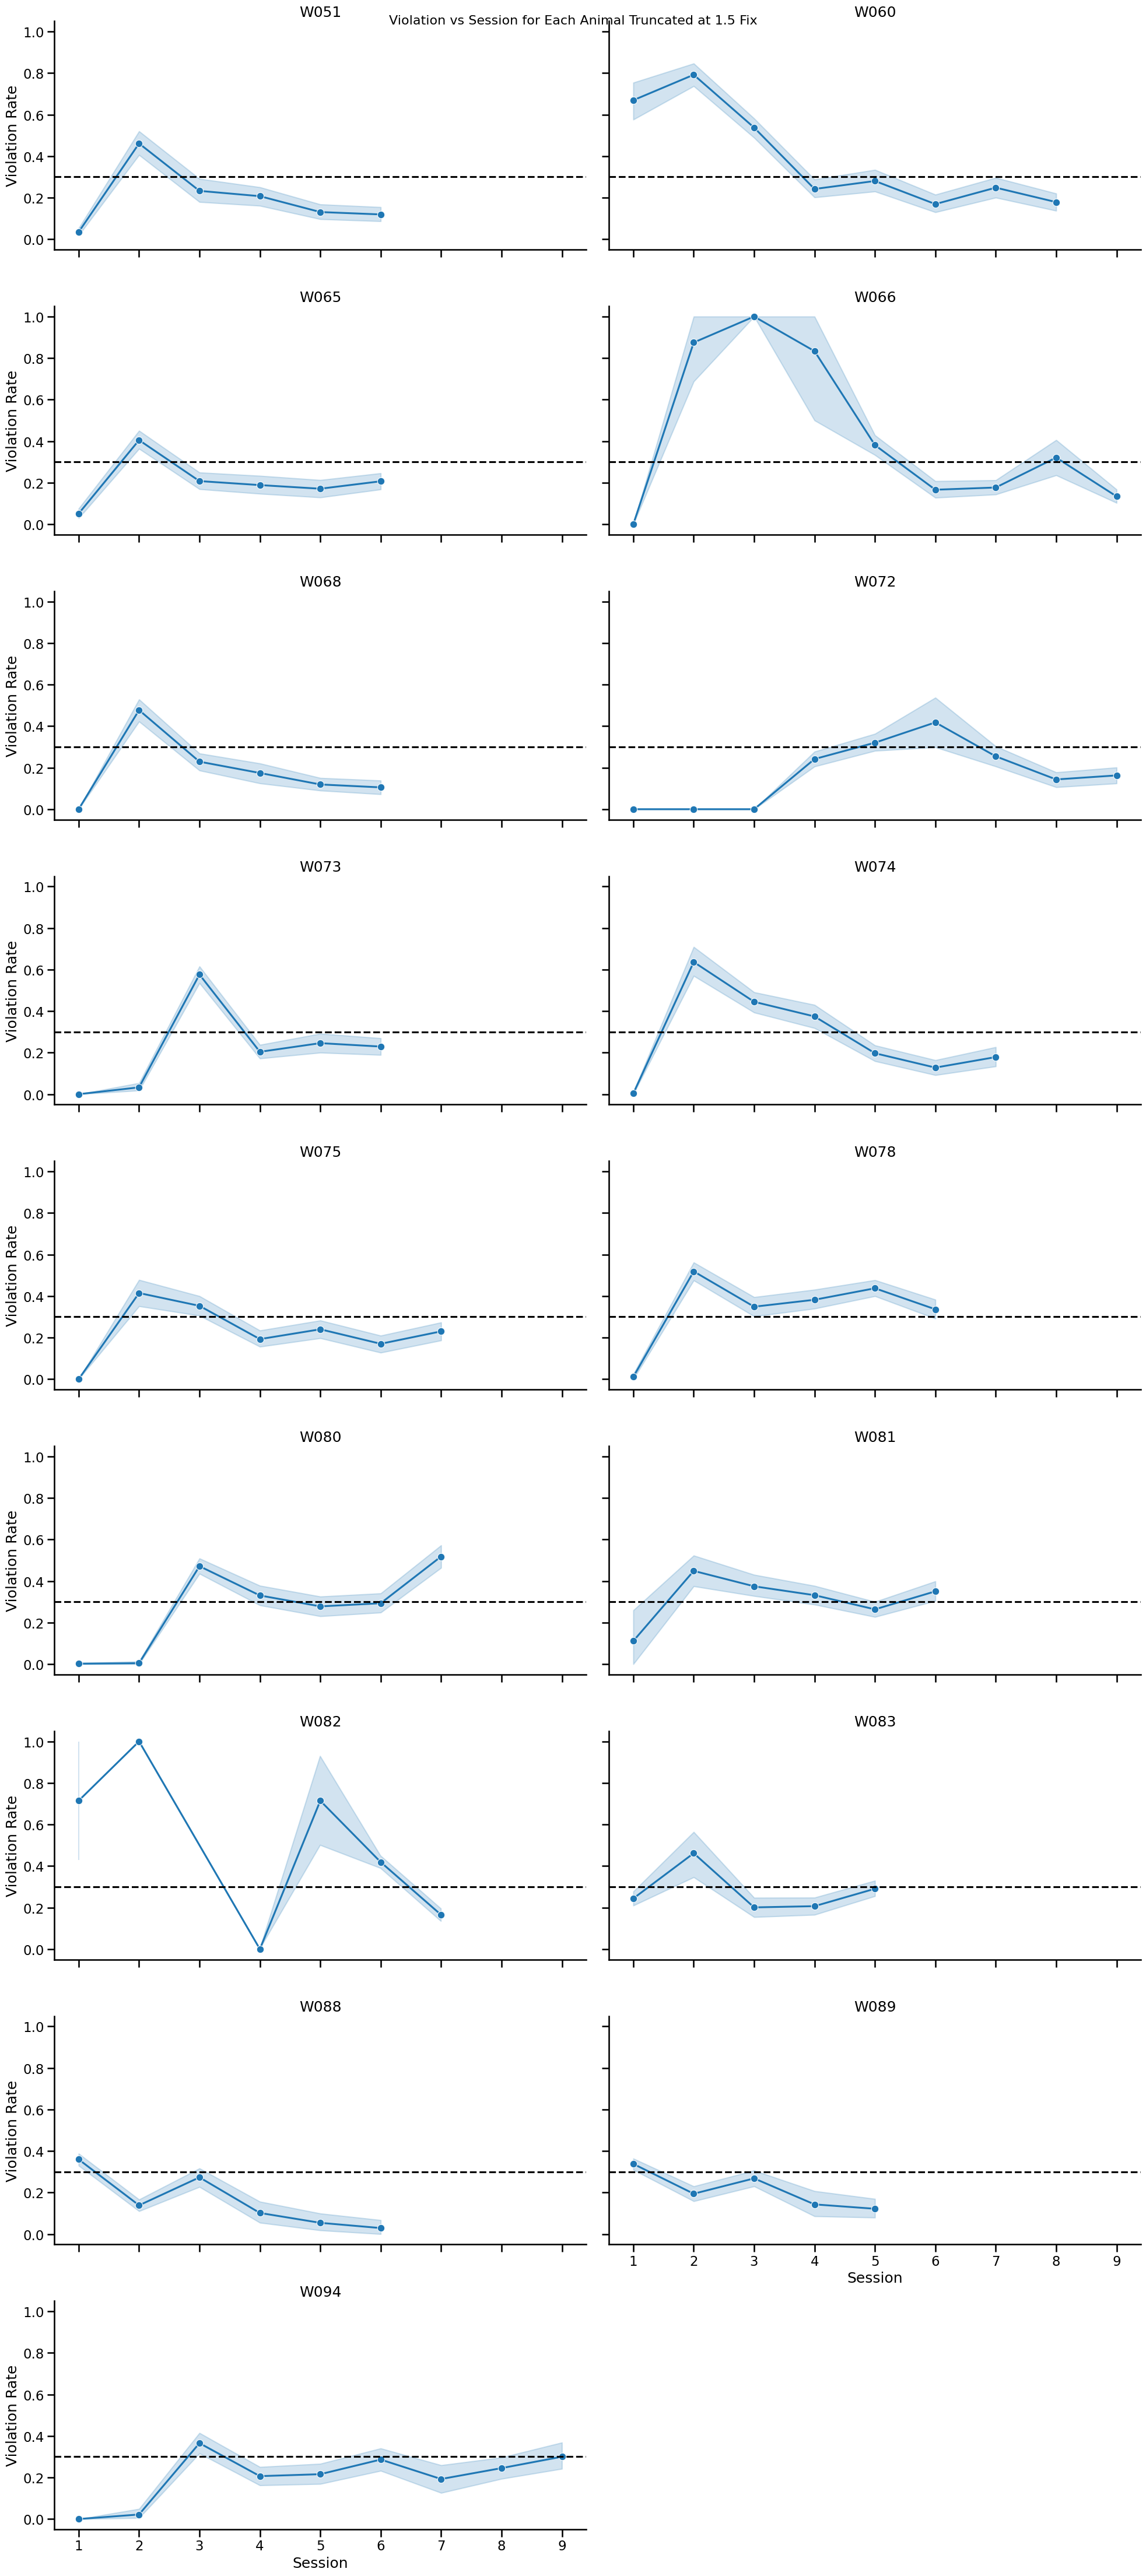

In [149]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df,
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(sns.lineplot, "session", "violation", marker="o", estimator="mean")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Violation vs Session for Each Animal Truncated at {threshold} Fix",
    fontsize=16,
)
g.set_axis_labels("Session", "Violation Rate")

g.map(plt.axhline, y=0.3, color="k", linestyle="--")

## Violation Rates

### Up to 1.5s Fixation

Text(0.5, 1.0, 'Viol/Session to 1.5s Fixation')

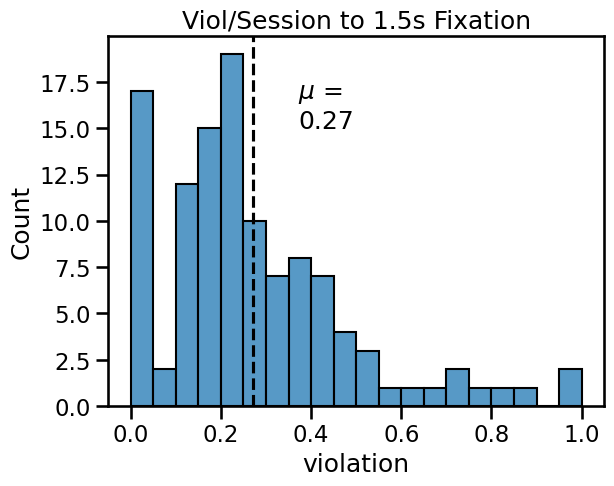

In [153]:
viol_rates_to_thresh = (
    short_del_df.groupby(["animal_id", "session"]).violation.mean().reset_index()
)

plot_df = viol_rates_to_thresh
sns.histplot(data=plot_df, x="violation", bins=20, binwidth=0.05)

mean = plot_df.violation.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.1, y=15, s=f"$\mu$ = \n{mean:.2f}")
plt.title("Viol/Session to 1.5s Fixation")

In [156]:
animals = plot_df.animal_id.nunique()
mean = plot_df.violation.mean().round(2)
std = plot_df.violation.std().round(2)
median = plot_df.violation.median().round(2)

print(
    f"**Results** \nN animals = {animals}\n"
    f"Mean = {mean} +/- {std} std\n"
    f"Median = {median}"
)

**Results** 
N animals = 17
Mean = 0.27 +/- 0.21 std
Median = 0.23


Text(0.5, 1.0, 'Viol/Session Stage 4')

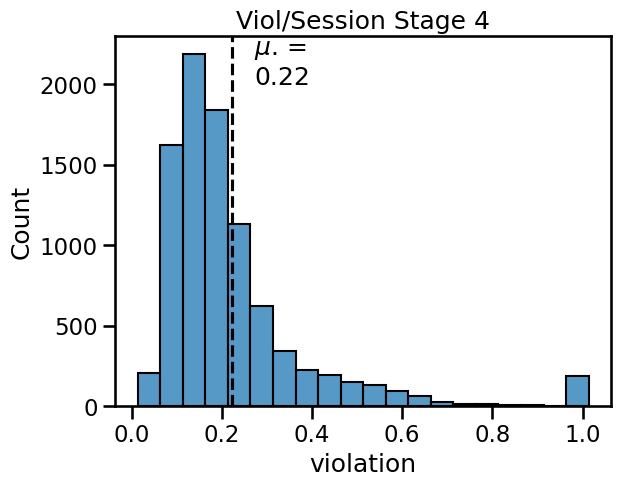

In [167]:
viol_rates_stg_4 = (
    df.query("training_stage >=4")
    .groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
)


plot_df = viol_rates_stg_4
sns.histplot(data=plot_df, x="violation", bins=20, binwidth=0.05)

mean = plot_df.violation.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.05, y=2000, s=f"$\mu$. = \n{mean:.2f}")
plt.title("Viol/Session Stage 4")

In [169]:
print(
    f"**Results** \nN animals = {animals}\n"
    f"Mean = {mean.round(2)} +/- {std} std\n"
    f"Median = {median}"
)

**Results** 
N animals = 17
Mean = 0.22 +/- 0.21 std
Median = 0.23


Text(0.5, 1.0, 'Viol/Session Stage 4')

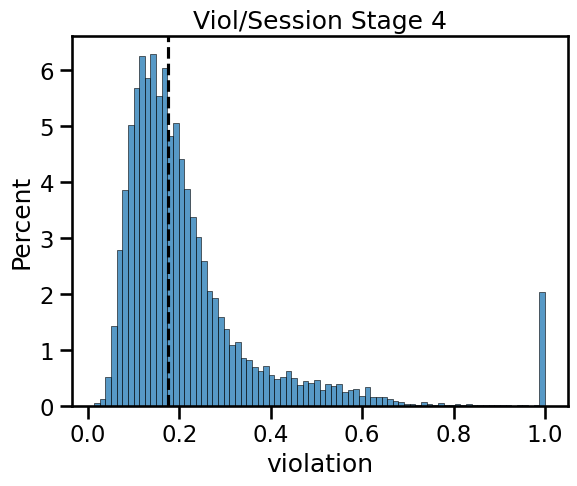

In [123]:
sns.histplot(data=plot_df, x="violation", stat="percent")

median = plot_df.violation.median()
plt.axvline(median, color="k", linestyle="--")
# plt.text(x=median + 0.1, y=15, s=f"med. = \n{median:.2f}")
plt.title("Viol/Session Stage 4")

In [ ]:
### Relationship between 1.5 session avg fixation rate and stage 4 session avg fixation rate for each aniaml

In [173]:
compare_viol_df = pd.DataFrame()
compare_viol_df["animal_id"] = df.animal_id.unique()

compare_viol_df["early_viol_rates"] = compare_viol_df["animal_id"].map(
    short_del_df.groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

compare_viol_df["late_viol_rates"] = compare_viol_df["animal_id"].map(
    df.query("training_stage >=4")
    .groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

compare_viol_df.head()

,animal_id,early_viol_rates,late_viol_rates
0,W051,0.197887,0.154241
1,W060,0.389829,0.140485
2,W065,0.205036,0.377705
3,W066,0.431885,0.268015
4,W068,0.184107,0.207301


(0.1, 0.6)

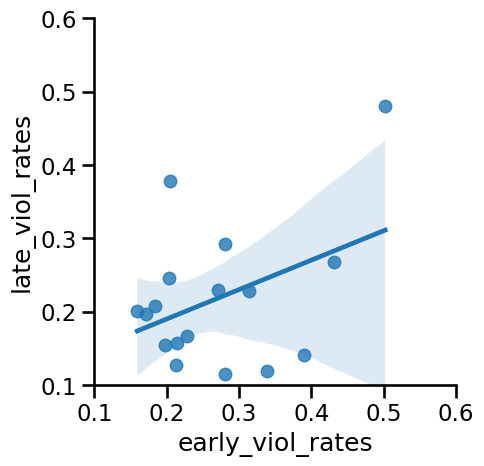

In [197]:
sns.lmplot(data=compare_viol_df, x="early_viol_rates", y="late_viol_rates")

plt.xlim(0.1, 0.6)
plt.ylim(0.1, 0.6)

(0.1, 0.6)

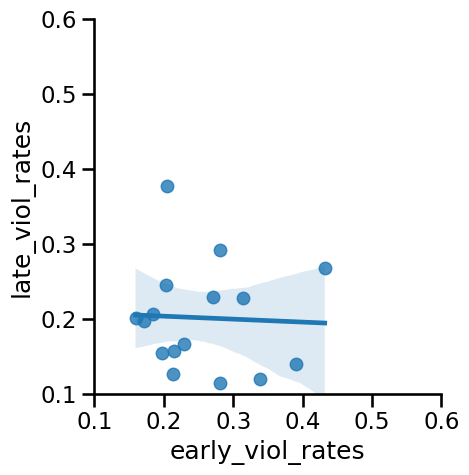

In [198]:
sns.lmplot(
    data=compare_viol_df.query("animal_id != 'W082'"),
    x="early_viol_rates",
    y="late_viol_rates",
)

plt.xlim(0.1, 0.6)
plt.ylim(0.1, 0.6)

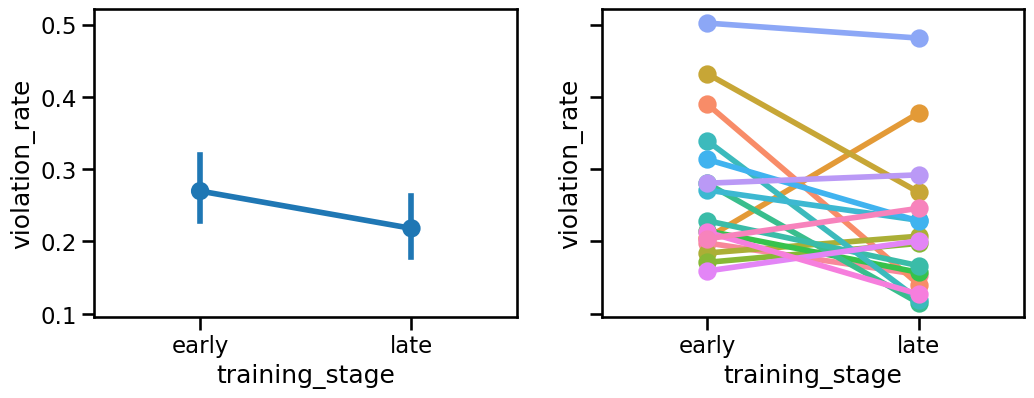

In [191]:
melted_df = compare_viol_df.melt(
    id_vars="animal_id",
    value_vars=["early_viol_rates", "late_viol_rates"],
    var_name="training_stage",
    value_name="violation_rate",
)

melted_df["training_stage"] = melted_df.training_stage.replace(
    {"early_viol_rates": "early", "late_viol_rates": "late"}
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.pointplot(data=melted_df, x="training_stage", y="violation_rate", ax=ax[0])
sns.pointplot(
    data=melted_df, x="training_stage", y="violation_rate", hue="animal_id", ax=ax[1]
)

# remove legend
ax[1].get_legend().remove()